<a href="https://colab.research.google.com/github/krishnarevi/TSAI_END2.0_Session9/blob/main/Part_2_BleuScore_PPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Packed Padded Sequences, Masking, Inference and BLEU

## Introduction

In this notebook we will be adding a few improvements - packed padded sequences and masking - to the model from the previous notebook. Packed padded sequences are used to tell our RNN to skip over padding tokens in our encoder. Masking explicitly forces the model to ignore certain values, such as attention over padded elements. Both of these techniques are commonly used in NLP. 

We will also look at how to use our model for inference, by giving it a sentence, seeing what it translates it as and seeing where exactly it pays attention to when translating each word.

Finally, we'll use the BLEU metric and Perplexity to measure the quality of our translations.

## Preparing Data

First, we'll import all the modules as before, with the addition of the `matplotlib` modules used for viewing the attention.

 We will be using `Multi30k <http://www.statmt.org/wmt16/multimodal-task.html#task1>`__ 
dataset to train a German to English translation model.

In [ ]:
%%bash
pip install -U spacy --quiet
python -m spacy download en --quiet
python -m spacy download de --quiet

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ As of spaCy v3.0, shortcuts like 'de' are deprecated. Please use the
full pipeline package name 'de_core_news_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


2021-07-10 11:18:37.639431: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-10 11:18:42.855910: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from typing import Iterable, List

# from typing import Tuple
# from torch import Tensor
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import spacy
import numpy as np
import random
import math
import time



Next, we'll set the random seed for reproducability.

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Data Sourcing and Processing


 In this example, we show how to use torchtext's inbuilt datasets, 
tokenize a raw text sentence, build vocabulary, and numericalize tokens into tensor. We will use
`Multi30k dataset from torchtext library <https://pytorch.org/text/stable/datasets.html#multi30k>`__
that yields a pair of source-target raw sentences. 





In [ ]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}


In [ ]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language="de_core_news_sm")
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language="en_core_web_sm")

In [ ]:

# helper function to yield list of tokens

def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

In [ ]:

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

In [ ]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  # Training data Iterator 
  train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
  # Create torchtext's Vocab object 
  vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

In [ ]:
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

Here we do NLP data processing with tokenizer and vocabulary using torchtext's new API. The first step is to build a vocabulary with the raw training dataset. Here we use built in factory function build_vocab_from_iterator which accepts iterator that yield list or iterator of tokens. Users can also pass any special symbols to be added to the vocabulary.

In [ ]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    
    src_batch,src_len_batch, tgt_batch = [], [],[]
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))
        src_len_batch.append(len(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))))
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    lengths = torch.LongTensor(src_len_batch)

    return src_batch,lengths, tgt_batch

Create test data loader

In [ ]:
test_iter = Multi30k(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))


Let's view one example from test set

In [ ]:
next(iter(test_iter))

('Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.\n',
 'A man in an orange hat starring at something.\n')

## Building the Model

### Encoder

Next up, we define the encoder.

The changes here all within the `forward` method. It now accepts the lengths of the source sentences as well as the sentences themselves. 

After the source sentence (padded automatically within the iterator) has been embedded, we can then use `pack_padded_sequence` on it with the lengths of the sentences. Note that the tensor containing the lengths of the sequences must be a CPU tensor as of the latest version of PyTorch, which we explicitly do so with `to('cpu')`. `packed_embedded` will then be our packed padded sequence. This can be then fed to our RNN as normal which will return `packed_outputs`, a packed tensor containing all of the hidden states from the sequence, and `hidden` which is simply the final hidden state from our sequence. `hidden` is a standard tensor and not packed in any way, the only difference is that as the input was a packed sequence, this tensor is from the final **non-padded element** in the sequence.

We then unpack our `packed_outputs` using `pad_packed_sequence` which returns the `outputs` and the lengths of each, which we don't need. 

The first dimension of `outputs` is the padded sequence lengths however due to using a packed padded sequence the values of tensors when a padding token was the input will be all zeros.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
                
        #need to explicitly put lengths on cpu!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'),enforce_sorted=False)
                
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

The attention module is where we calculate the attention values over the source sentence. 

Previously, we allowed this module to "pay attention" to padding tokens within the source sentence. However, using *masking*, we can force the attention to only be over non-padding elements.

The `forward` method now takes a `mask` input. This is a **[batch size, source sentence length]** tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: ["hello", "how", "are", "you", "?", `<pad>`, `<pad>`], then the mask would be [1, 1, 1, 1, 1, 0, 0].

We apply the mask after the attention has been calculated, but before it has been normalized by the `softmax` function. It is applied using `masked_fill`. This fills the tensor at each element where the first argument (`mask == 0`) is true, with the value given by the second argument (`-1e10`). In other words, it will take the un-normalized attention values, and change the attention values over padded elements to be `-1e10`. As these numbers will be miniscule compared to the other values they will become zero when passed through the `softmax` layer, ensuring no attention is payed to padding tokens in the source sentence.

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

### Decoder

The decoder only needs a few small changes. It needs to accept a mask over the source sentence and pass this to the attention module. As we want to view the values of attention during inference, we also return the attention tensor.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq

The overarching seq2seq model also needs a few changes for packed padded sequences, masking and inference. 

We need to tell it what the indexes are for the pad token and also pass the source sentence lengths as input to the `forward` method.

We use the pad token index to create the masks, by creating a mask tensor that is 1 wherever the source sentence is not equal to the pad token. This is all done within the `create_mask` function.

The sequence lengths as needed to pass to the encoder to use packed padded sequences.

The attention at each time-step is stored in the `attentions` 

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, tgt, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #tgt = [tgt len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        tgt_len = tgt.shape[0]
        tgt_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(tgt_len, batch_size, tgt_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <bos> tokens
        input = tgt[0,:]
        
        mask = self.create_mask(src)

        #mask = [batch size, src len]
                
        for t in range(1, tgt_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = tgt[t] if teacher_force else top1
              
        return outputs

## Training the Seq2Seq Model

Next up, initializing the model and placing it on the GPU.

In [ ]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TGT_LANGUAGE])
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
# SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
SRC_PAD_IDX=PAD_IDX

BATCH_SIZE = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

Then, we initialize the model parameters.

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(19215, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(10838, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=10838, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

We'll print out the number of trainable parameters in the model, noticing that it has the exact same amount of parameters as the model without these improvements.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 33,559,382 trainable parameters


Then we define our optimizer and criterion. 

The `ignore_index` for the criterion needs to be the index of the pad token for the target language, not the source language.

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)


## BLEU
Bleu is specifically designed for measuring the quality of a translation . BLEU looks at the overlap in the predicted and actual target sequences in terms of their n-grams. It will give us a number between 0 and 1 for each sequence, where 1 means there is perfect overlap, i.e. a perfect translation, although is usually shown between 0 and 100. 

Here we use `bleu_score` function from torchtext metrics to calculate bleu score.

Following are parameters of `bleu_score`:

* candidate_corpus – an iterable of candidate translations. Each translation is 
an iterable of tokens

* references_corpus – an iterable of iterables of reference translations. Each translation is an iterable of tokens

* max_n – the maximum n-gram we want to use. E.g. if max_n=3, we will use unigrams, bigrams and trigrams
* weights – a list of weights used for each n-gram category (uniform by default)



Here we calculate bleu based on maximum n-grams as 4.

In [ ]:
from torchtext.data.metrics import bleu_score

Next, we'll define our training and evaluation loops.


In [ ]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    epoch_loss = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    
    for src,src_len, tgt in train_dataloader:
        # get the source and target sentences from the batch
        src = src.to(device)
        tgt = tgt.to(device)
        #tgt = [(tgt len - 1) * batch size]
        #output = [(tgt len - 1) * batch size, output dim]
     
        optimizer.zero_grad() #zero the gradients calculated from the last batch
        output = model(src,src_len, tgt)  #feed the source and target into the model to get the output
        
        # as the loss function only works on 2d inputs with 1d targets we need to flatten each of them with .view
        output = output[1:].view(-1, output.shape[-1]) #shape of output = [(tgt len - 1) * batch size, output dim]
        tgt = tgt[1:].view(-1)# shape of target  = [(tgt len - 1) * batch size]
        
        loss = criterion(output, tgt) #calculate loss
        loss.backward() #calculate the gradients
        clip = 1
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)# clip the gradients to prevent them from exploding

        optimizer.step() #update weights
        epoch_loss += loss.item() #sum the loss value to a running total

    return epoch_loss / len(train_dataloader)



def evaluate(model):
    model.eval()
    epoch_loss = 0
    epoch_bleu = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE)) # Load validation dataset
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn) # create  dataloader

    for src,src_len, tgt in val_dataloader:
        # get the source and target sentences from the batch
        src = src.to(device)
        tgt = tgt.to(device)
        
        #shape of tgt = [tgt len, batch size]
        #shape of output = [tgt len, batch size, output dim]

        output = model(src,src_len, tgt,0)  #turn off teacher forcing
        
        # following part of code is dedicated to bleu score calculation 

        tgt_t =tgt.transpose(1,0) # swap dim0 and dim 1 to get each row as a sentence ,shape of tgt_t = [batch size,tgt len]
        out=output.argmax(2) # shape of output is [tgt len, batch size, output dim] , select token predicted with maximum score from dim 2
        out_t=out.transpose(1,0) # swap dim0 and dim 1 to get each row as a sentence , shape of out_t = [batch size,tgt len]

        tgt_list=[]
        out_list=[]

        for o,t in zip(out_t,tgt_t): # select each sentence tensor from output batch and target batch
          if  EOS_IDX in o: # if <eos> token is present in tensor , select index
            o_idx = (o == EOS_IDX).nonzero()[0].item()
          else :
            o_idx =len(o)

          t_idx = (t == EOS_IDX).nonzero()[0].item()
          
          tgt_indices = t[:t_idx] # trim tensor till <eos> token
          out_indices = o[:o_idx] # trim tensor till <eos> token

          tgt_tokens=vocab_transform[TGT_LANGUAGE].lookup_tokens([i.int() for i in tgt_indices]) # convert indices into string tokens with vocab transform 
          out_tokens=vocab_transform[TGT_LANGUAGE].lookup_tokens([i.int() for i in out_indices]) # convert indices into string tokens with vocab transform 

          tgt_list.append([tgt_tokens[1:]]) # append each target sentence to create reference corpus
          out_list.append(out_tokens[1:]) # append each target sentence to create candidate corpus
        # print("tgt_list",tgt_list)
        # print("out_list",out_list)
        bleu=bleu_score(out_list,tgt_list)


        # Reshaping output and target tensor so that it is suitable for crossentrophy loss 
        output = output[1:].view(-1, output.shape[-1]) #shape of output = [(tgt len - 1) * batch size, output dim]
        tgt = tgt[1:].view(-1)# shape of target  = [(tgt len - 1) * batch size]

        loss = criterion(output, tgt)#calculate loss
        epoch_loss += loss.item() # #sum the loss value to a running total
        epoch_bleu +=bleu # #sum the bleu score to a running total
  

    return epoch_loss / len(val_dataloader), epoch_bleu / len(val_dataloader)


Let's do training 

In [ ]:
from timeit import default_timer as timer
NUM_EPOCHS = 10

train_los=[]
val_los=[]
bleu_value=[]
train_ppl=[]
val_ppl=[]
best_val_loss = float('inf')

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer)
    train_los.append(train_loss)
    train_ppl.append(math.exp(train_loss))  
    end_time = timer()
    val_loss,bleu = evaluate(model)
    val_los.append(val_loss)
    val_ppl.append(math.exp(val_loss))
    bleu_value.append(bleu)

        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'saved-model.pt')
  

    print(f'\t Epoch: {epoch}  | Epoch time : {(end_time - start_time):.3f}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. PPL: {math.exp(val_loss):7.3f}')
    print(f'BLEU score = {bleu*100:.2f}')

	 Epoch: 1  | Epoch time : 147.384s
	Train Loss: 4.324 | Train PPL:  75.461
	 Val. Loss: 4.062 |  Val. PPL:  58.110
BLEU score = 16.19
	 Epoch: 2  | Epoch time : 147.379s
	Train Loss: 3.027 | Train PPL:  20.632
	 Val. Loss: 3.611 |  Val. PPL:  37.004
BLEU score = 24.61
	 Epoch: 3  | Epoch time : 148.177s
	Train Loss: 2.409 | Train PPL:  11.120
	 Val. Loss: 3.568 |  Val. PPL:  35.445
BLEU score = 27.17
	 Epoch: 4  | Epoch time : 148.082s
	Train Loss: 1.974 | Train PPL:   7.198
	 Val. Loss: 3.651 |  Val. PPL:  38.517
BLEU score = 28.53
	 Epoch: 5  | Epoch time : 148.030s
	Train Loss: 1.681 | Train PPL:   5.374
	 Val. Loss: 3.737 |  Val. PPL:  41.964
BLEU score = 29.14
	 Epoch: 6  | Epoch time : 147.860s
	Train Loss: 1.495 | Train PPL:   4.459
	 Val. Loss: 3.779 |  Val. PPL:  43.777
BLEU score = 29.60
	 Epoch: 7  | Epoch time : 147.531s
	Train Loss: 1.347 | Train PPL:   3.845
	 Val. Loss: 3.901 |  Val. PPL:  49.452
BLEU score = 30.19
	 Epoch: 8  | Epoch time : 147.674s
	Train Loss: 1.228 

Let's visualize loss and evaluation metrics

Loss

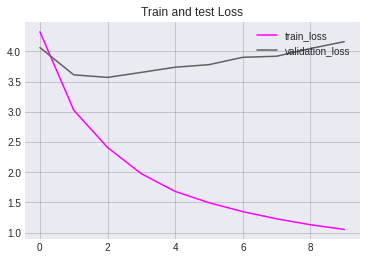

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(train_los, color = 'magenta')
plt.plot(val_los, color = '#606060')
plt.title('Train and test Loss')
plt.legend(['train_loss', 'validation_loss'], loc = 'upper right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)

Here we observe our training loss keep on decreasing ,which is good but validaton loss increases after dip in some initial epochs .This could be due to our model is overfitting to the training data. We can try adding regularization and reducing model capacity.

Bleu score

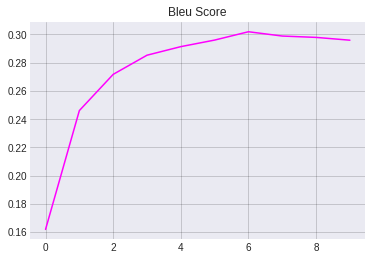

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(bleu_value, color = 'magenta')
plt.title('Bleu Score')
# plt.legend(['train_loss', 'validation_loss'], loc = 'upper right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)

The most useful part of a BLEU score is that it can be used to compare different models on the same dataset, where the one with the **higher** BLEU score is "better".We have our best validation Bleu score over 30 . According to General interpretability of scale published in this paper https://www.researchgate.net/publication/282133384_Neural-based_Machine_Translation_for_Medical_Text_Domain_Based_on_European_Medicines_Agency_Leaflet_Texts
Scores over 30 generally reflect understandable translations.
So our model give understandable translations according to Bleu score and that's good !!


Perplexity

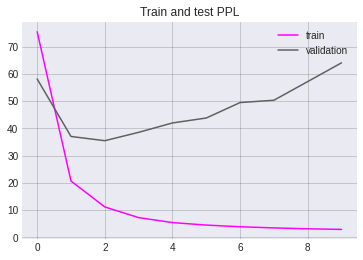

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(train_ppl, color = 'magenta')
plt.plot(val_ppl, color = '#606060')
plt.title('Train and test PPL')
plt.legend(['train', 'validation'], loc = 'upper right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)

Intuitively, Perplexity can be thought of as an evaluation of the model’s ability to predict uniformly among the set of specified tokens in a corpus.Smaller the perplexity better the model . Here we can observe perplexity for train set keep on decreasing ,which is good.But for validation set it increases after dip in some initial epochs . This might be due to overfitting of our model on training data

## Inference

Now we can use our trained model to generate translations.

**Note:** these translations will be poor compared to examples shown in paper as they use hidden dimension sizes of 1000 and train for 4 days! They have been cherry picked in order to show off what attention should look like on a sufficiently sized model.

Our `translate` function will do the following:
- ensure our model is in evaluation mode, which it should always be for inference
- Apply text transformations to the source sentence
- convert it to a tensor and add a batch dimension
- get the length of the source sentence and convert to a tensor
- feed the source sentence into the encoder
- create the mask for the source sentence
- create a list to hold the output sentence, initialized with an `<sos>` token
- create a tensor to hold the attention values
- while we have not hit a maximum length
  - get the input tensor, which should be either `<sos>` or the last predicted token
  - feed the input, all encoder outputs, hidden state and mask into the decoder
  - store attention values
  - get the predicted next token
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
-Join tokens to form output sentence
- return the output sentence ,output tokens (with the `<sos>` token removed) and the attention values over the sequence

In [ ]:
# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str,max_len=50):
    model.eval()

    src_indexes = text_transform[SRC_LANGUAGE](src_sentence)

    # src_indexes=tokens
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)])

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
    tgt_indexes = vocab_transform[TGT_LANGUAGE](['<bos>'])
    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    for i in range(max_len):

        tgt_tensor = torch.LongTensor([tgt_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(tgt_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        tgt_indexes.append(pred_token)

        if pred_token == EOS_IDX:
            break
    
    tgt_tokens = vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_indexes))
    pred_sentence=" ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_indexes))).replace("<bos>", "").replace("<eos>", "")
    
    return pred_sentence,tgt_tokens[1:], attentions[:len(tgt_tokens)-1]



Next, we'll make a function that displays the model's attention over the source sentence for each target token generated.

In [ ]:
import matplotlib.ticker as ticker
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<bos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Now, we'll grab some translations from our dataset and see how well our model did. Note, we're going to cherry pick examples here so it gives us something interesting to look at, but feel free to change the `example_idx` value to look at different examples.

First, we'll get a source and target from our dataset.

In [ ]:
src,tgt=next(iter(test_iter))
src=src.rstrip("\n")
tgt=tgt.rstrip("\n")
print(f'src = {src}')
print(f'tgt = {tgt}')

translation,tgt_tokens, attention =translate(model,src )

print(f'predicted tgt = {translation}')


src = Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.
tgt = A Boston Terrier is running on lush green grass in front of a white fence.
predicted tgt =  A skinny dog runs over grass grass in front of a white fence . 


In [ ]:
src,tgt=next(iter(test_iter))
src=src.rstrip("\n")
tgt=tgt.rstrip("\n")
print(f'src = {src}')
print(f'tgt = {tgt}')

translation,tgt_tokens, attention =translate(model,src )

print(f'predicted tgt = {translation}')

src = Ein Mädchen in einem Karateanzug bricht einen Stock mit einem Tritt.
tgt = A girl in karate uniform breaking a stick with a front kick.
predicted tgt =  A girl in a karate outfit is a a pool with a sports game . 


In [ ]:
src,tgt=next(iter(test_iter))
src=src.rstrip("\n")
tgt=tgt.rstrip("\n")
print(f'src = {src}')
print(f'tgt = {tgt}')

translation,tgt_tokens, attention =translate(model,src )

print(f'predicted tgt = {translation}')

src = Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund.
tgt = Five people wearing winter jackets and helmets stand in the snow, with snowmobiles in the background.
predicted tgt =  Five people in winter suits and helmets are in snow with helmets in the background . 


In [ ]:
src,tgt=next(iter(test_iter))
src=src.rstrip("\n")
tgt=tgt.rstrip("\n")
print(f'src = {src}')
print(f'tgt = {tgt}')

translation,tgt_tokens, attention =translate(model,src )

print(f'predicted tgt = {translation}')

src = Leute Reparieren das Dach eines Hauses.
tgt = People are fixing the roof of a house.
predicted tgt =  People are cleaning the roof of a building . 


Then we'll use our `translate` function to get our predicted translation and attention of a random german sentence. We show this graphically by having the source sentence on the x-axis and the predicted translation on the y-axis. The lighter the square at the intersection between two words, the more attention the model gave to that source word when translating that target word.

Below is an example the model attempted to translate,"*Eine Gruppe von Menschen steht vor einem Iglu .*" which means " *A group of people standing in an Iglu* ". it gets the translation correct .

In [ ]:
src_sentence="Eine Gruppe von Menschen steht vor einem Iglu ."
translation,tgt_tokens, attention =translate(model,src_sentence )

print(f'predicted tgt = {translation}')

predicted tgt =  A group of people standing in front of an obstacle . 


In [ ]:
src = token_transform[SRC_LANGUAGE](src_sentence)
# tgt = vars(train_data.examples[example_idx])['tgt']

print(f'src = {src}')
# print(f'tgt = {tgt}')

src = ['Eine', 'Gruppe', 'von', 'Menschen', 'steht', 'vor', 'einem', 'Iglu', '.']


In [ ]:
tgt_tokens

['A',
 'group',
 'of',
 'people',
 'standing',
 'in',
 'front',
 'of',
 'an',
 'obstacle',
 '.',
 '<eos>']

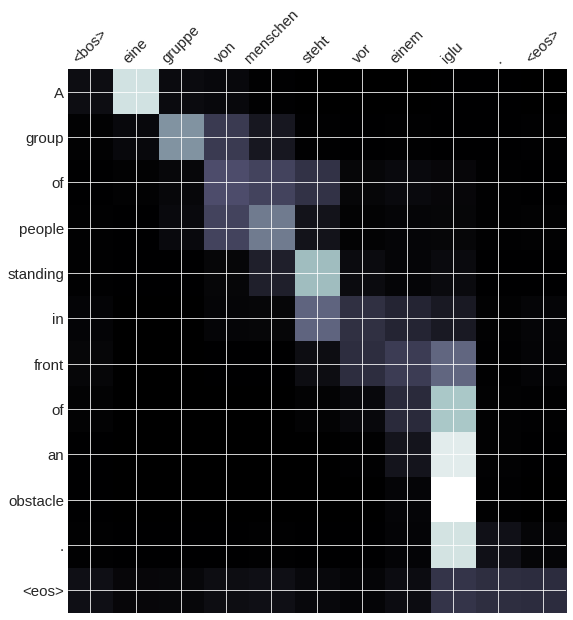

In [ ]:
display_attention(src, tgt_tokens, attention)

Next we'll write a function to calculate bleu score of our test set

In [ ]:
from torchtext.data.metrics import bleu_score
# sentence, src_field, tgt_field, model, device, max_len = 50
def calculate_bleu(data, model, max_len = 50):
    
    tgts = []
    pred_tgts = []


    for datum in data:
      # print(datum)
      # break
        
        src = datum[0].rstrip("\n")
        # print(src)
        tgt = token_transform[TGT_LANGUAGE](datum[1].rstrip("\n"))
        
        translation, pred_tgt,_ = translate( model,src)
      
        #cut off <eos> token
        pred_tgt = pred_tgt[:-1]
        
        pred_tgts.append(pred_tgt)
        tgts.append([tgt])
        
    return bleu_score(pred_tgts, tgts)


Here we can see our test set is giving a bleu score of 32.19, which is also good considering model complexity and time taken for training.

In [ ]:
bleu_score = calculate_bleu(test_iter, model)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 32.19
